In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from construct import *

import collections

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.max_open_warning'] = 0

In [2]:
frames = np.fromfile('europa_clipper_frames.u8', 'uint8').reshape(-1, 1113)
frames.shape

(2023, 1113)

In [3]:
TMFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes,
)

# AOS frames

Europa Clipper transmits AOS frames without OCF. The spacecraft ID is `0x9f`, which is [assigned in SANA registry](https://sanaregistry.org/r/spacecraftid/records/15124). Virtual channels 32 and 63 (only-idle-data) are in use.

In [4]:
hex(159)

'0x9f'

In [5]:
tm = [TMFrame.parse(f) for f in frames]
scid = [a.primary_header.spacecraft_id for a in tm]
vcid = np.array([a.primary_header.virtual_channel_id for a in tm])
vcfc = np.array([a.primary_header.virtual_channel_frame_count for a in tm])
[a.primary_header for a in tm[:10]]

[Container(transfer_frame_version_number=1, spacecraft_id=159, virtual_channel_id=32, virtual_channel_frame_count=2941039, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=159, virtual_channel_id=32, virtual_channel_frame_count=2941040, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=159, virtual_channel_id=32, virtual_channel_frame_count=2941042, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=159, virtual_channel_id=32, virtual_channel_frame_count=2941043, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=159, virtual_channel_id=32, virtual_channel_frame_count=2941045, replay_flag=False, vc_fra

In [6]:
collections.Counter(scid)

Counter({159: 2023})

In [7]:
collections.Counter(vcid)

Counter({np.int64(32): 2021, np.int64(63): 2})

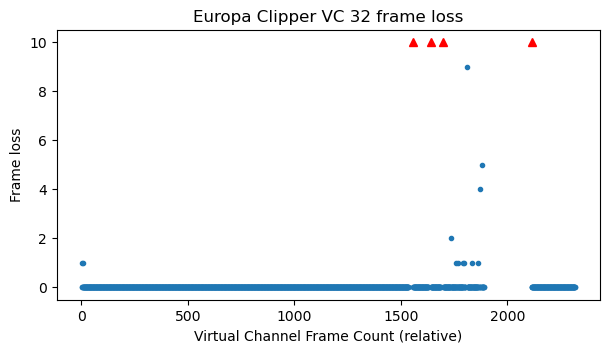

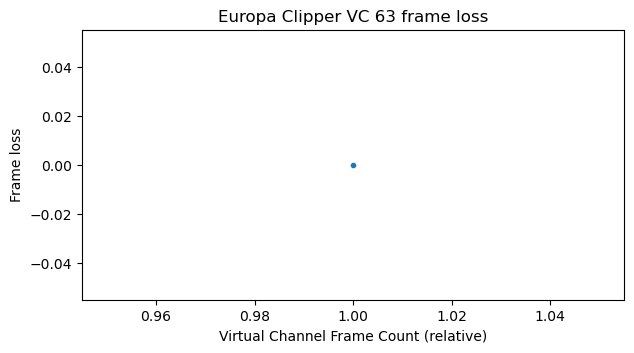

In [8]:
for v in set(vcid):
    relfn = vcfc[vcid == v][1:] - vcfc[vcid == v][0]
    loss = np.diff(vcfc[vcid == v]) - 1
    M = 10
    plt.figure()
    plt.plot(relfn[loss <= M], loss[loss <= M], '.')
    plt.plot(relfn[loss > M], [M] * np.sum(loss > M), '^', color='red')
    plt.title(f'Europa Clipper VC {v} frame loss')
    plt.xlabel('Virtual Channel Frame Count (relative)')
    plt.ylabel('Frame loss');

# VC 32

Virtual channel 32 contains real-time telemetry using space packets. APIDs 5-8 and 10-13, and 2047 (idle) are used. All the APIDs except 2047 use a 6-byte secondary header that contains a timestamp. APIDs 5-8 carry "sentences" prefixed by an ASCII string of hex digits. APIDs 10-13 use key-value format. APID 2047 packets carry an easter egg message.

In [9]:
packets = list(ccsds.extract_space_packets(tm, 0x9f, 32))

/home/daniel/contracting/Europa_Clipper/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 159 VC 32] Broken stream. Last frame count 2941040, current frame count 2941042
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Europa_Clipper/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 159 VC 32] Broken stream. Last frame count 2941043, current frame count 2941045
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Europa_Clipper/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 159 VC 32] Broken stream. Last frame count 2942574, current frame count 2942596
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {f

In [10]:
headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]
apids = collections.Counter([p.APID for p in headers])
apids

Counter({6: 8839,
         12: 5188,
         11: 5012,
         13: 887,
         2047: 716,
         10: 433,
         8: 423,
         5: 192,
         7: 4})

In [11]:
headers[:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=11, sequence_flags=3, packet_sequence_count_or_name=10989, data_length=25),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=12, sequence_flags=3, packet_sequence_count_or_name=13474, data_length=77),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=12, sequence_flags=3, packet_sequence_count_or_name=13475, data_length=205),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=12, sequence_flags=3, packet_sequence_count_or_name=13476, data_length=29),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=12, sequence_flags=3, packet_sequence_count_or_name=13477, data_length=135),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=13, sequence_flags=3, packet_sequence_count_or_name=1406, data_length=767),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=12, sequen

In [12]:
[h for h in headers if h.APID == 2047][:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6086, data_length=641),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6087, data_length=1030),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6088, data_length=728),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6089, data_length=1030),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6090, data_length=650),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6091, data_length=888),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=Fal

In [13]:
assert all([h.secondary_header_flag for h in headers if h.APID != 2047])
assert all([not h.secondary_header_flag for h in headers if h.APID == 2047])

In [14]:
by_apid = {apid: [p for p, h in zip(packets, headers) if h.APID == apid]
           for apid in apids}

In [15]:
longest_idle = by_apid[2047][np.argmax([len(p) for p in by_apid[2047]])]
print(str(longest_idle[ccsds.SpacePacketPrimaryHeader.sizeof():], encoding='ascii'))

N.Alderson M.Aleem K.Altimus R.Banduric A.Black
I.Brault J.Brown B.Campuzano B.Chen S.Cheng S.Chou
N.Chow T.Clark N.Colindres D.Cummings J.Davis
A.Diaz-Calderon A.Dobrev P.Doronila B.Duckett
J.Fernandez D.Gaines G.Gandhi R.Gio K.Gov D.Hahn
L.Hall S.Harris J.Hennawy K.Jones M.Jordan R.Joshi
D.Karlsson C.Kellerman D.Kessler S.Khan J.Kochocki
R.Largaespada L.Manglapus N.Markovitch S.Mikaelian
L.Miller B.Morin N.Nguyen A.Niessner C.Oda
C.Parker P.Partikian J.Pelayo I.Peng S.Reddy
L.Reder K.Reinholtz M.Rodriguez-Chen K.Roffo
P.Romano K.Rosario M.Sandoval T.Seto-Mook C.Skeggs
A.Smith D.Tran M.Tuszynski I.Uchenik M.Wade E.Wang
C.Williams V.Woo P.Dunn S.Hornbeck S.Lai A.Moncada
T.Neilson M.Thielman J.Walker T.Wysocky J.Lam
G.Singh C.Ballard J.Berman J.Bowles-Martinez
C.Brennan B.Cantos J.Castet E.Dodd M.Jackson
A.Kerzhner R.Kinnett G.Lee R.Morillo M.Salami
B.Smith M.Soriano C.Swan B.Ferdowsi D.Hecox
A.Holloway C.Hua C.Jones D.Kou J.Lai D.Leang
S.Scandore A.StAmand V.Verma K.Weiss

and many oth

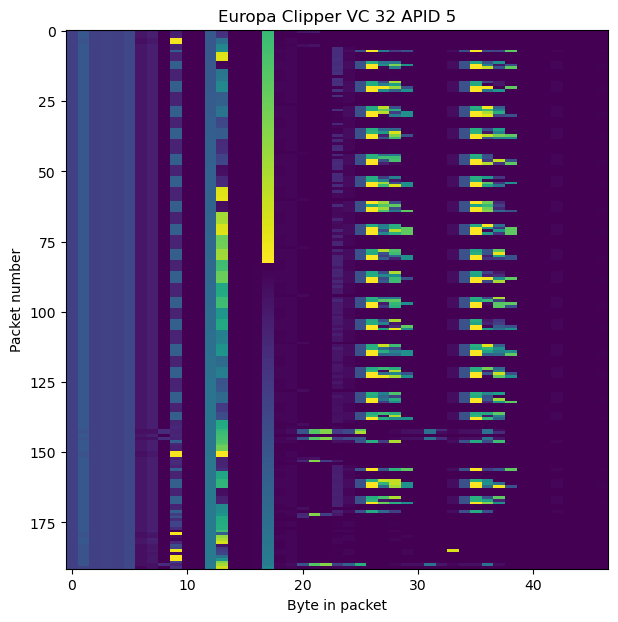

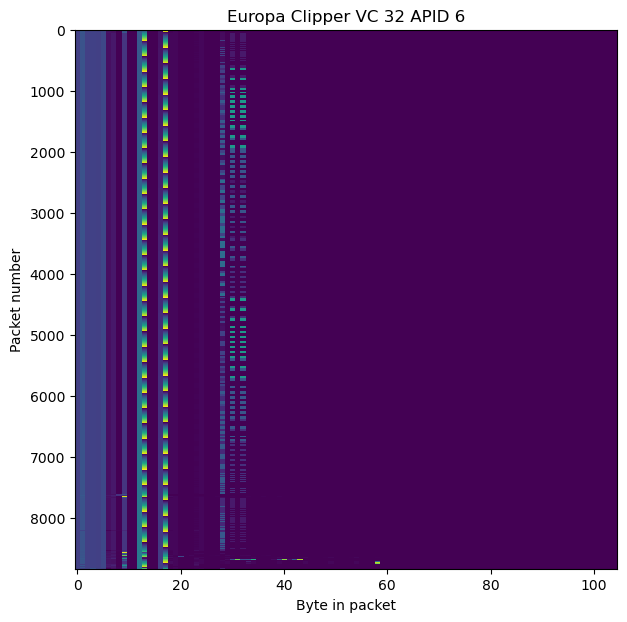

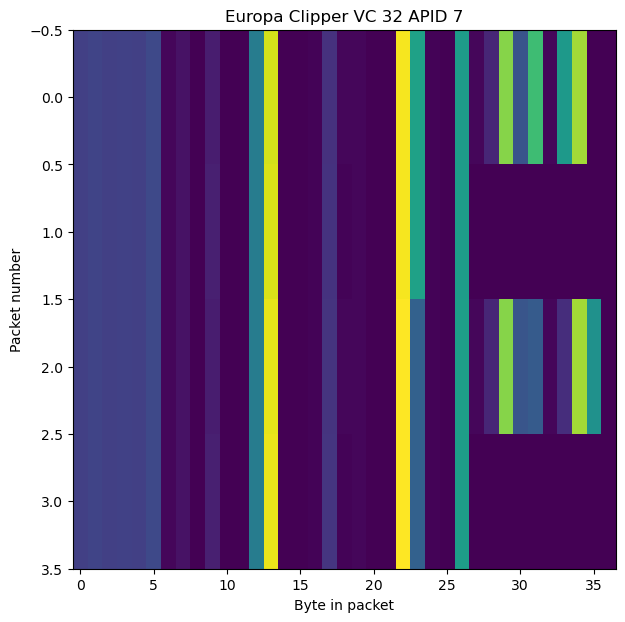

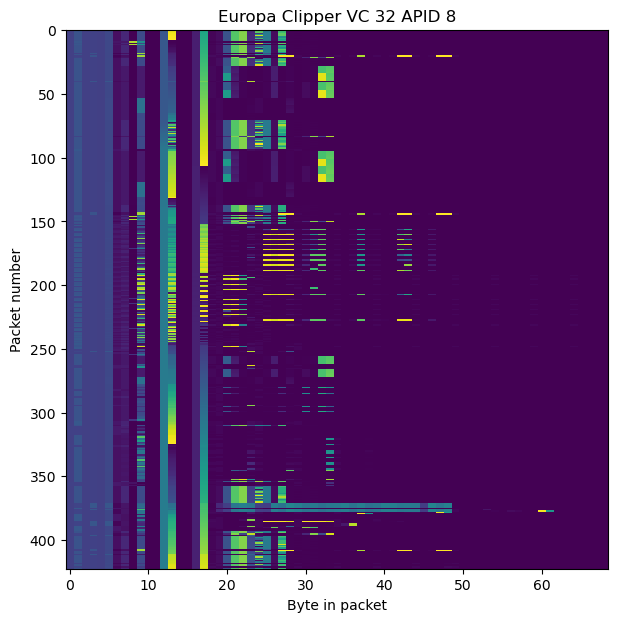

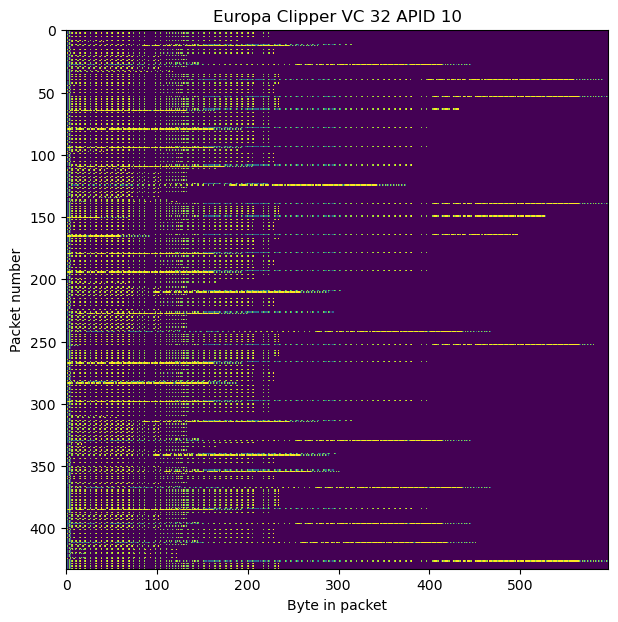

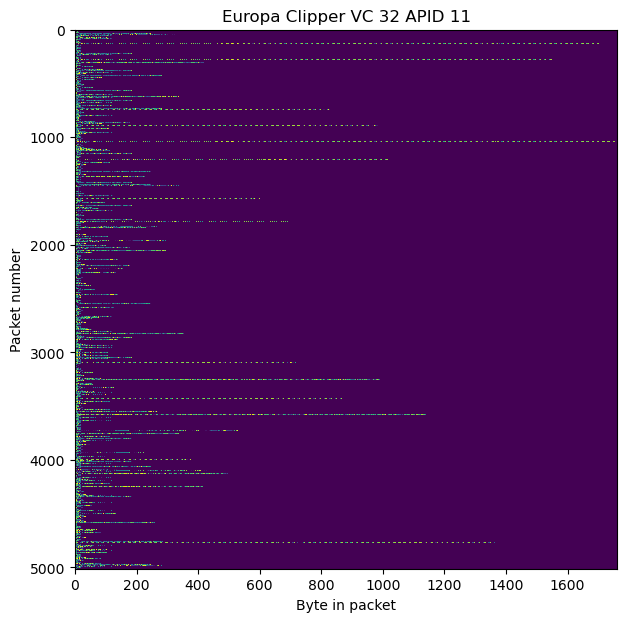

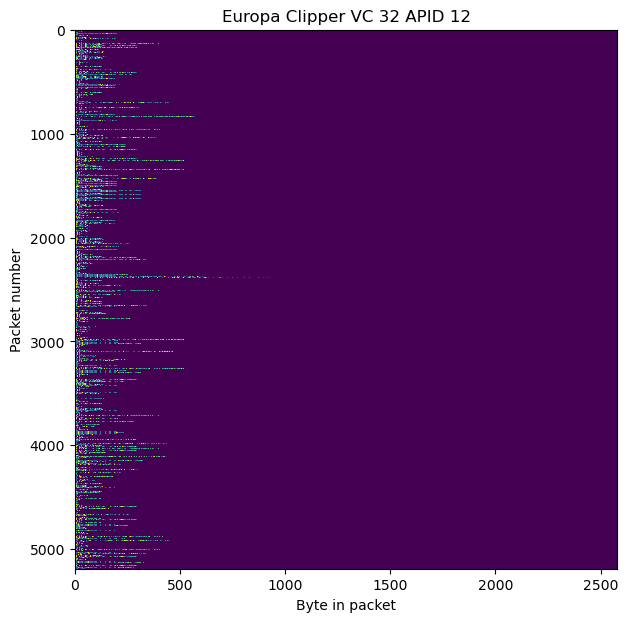

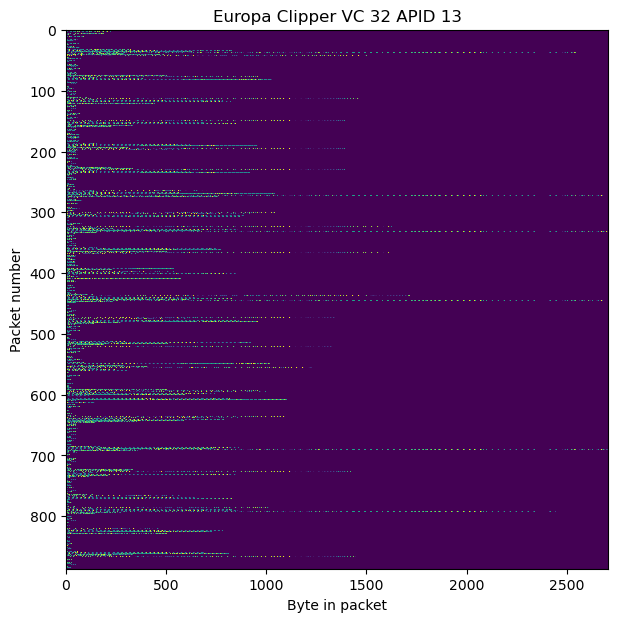

In [16]:
apid_array = {}
for apid in sorted(apids):
    if apid == 2047:
        continue
    ps = [np.frombuffer(p[6+6:], 'uint8') for p in by_apid[apid]]
    ml = max([len(p) for p in ps])
    plt.figure(figsize=(7, 7))
    apid_array[apid] = np.array([np.concatenate((p, np.zeros(ml - len(p), 'uint8'))) for p in ps])
    plt.imshow(apid_array[apid], aspect='auto', interpolation='none')
    plt.title(f'Europa Clipper VC 32 APID {apid}')
    plt.xlabel('Byte in packet')
    plt.ylabel('Packet number')

In [17]:
sec_headers = np.array([np.frombuffer(p[6:6+6], 'uint8') for p, h in zip(packets, headers)
                        if h.secondary_header_flag])
timestamps = (sec_headers[:, :4].view('uint32').byteswap().ravel()
              + sec_headers[:, -2:].view('uint16').byteswap().ravel() / 2**16)

# https://naif.jpl.nasa.gov/pub/naif/EUROPACLIPPER/kernels/sclk/europaclipper_00020.tsc
#
# SCLK01_COEFFICIENTS_159     = ( 
#
#                   0     @01-JAN-2010-00:01:06.184000     1.00000000000         
# )

def timestamp_to_utc(t):
    return np.datetime64('2010-01-01T00:01:06.184') + np.timedelta64(1, 'ns') * (1e9 * t)

packet_timestamps = timestamp_to_utc(timestamps)
packet_timestamps[0]

np.datetime64('2024-10-14T17:35:47.990961088')

In [18]:
headers_noidle = [h for h in headers if h.APID != 2047]
packets_noidle = [p for h, p in zip(headers, packets) if h.APID != 2047]

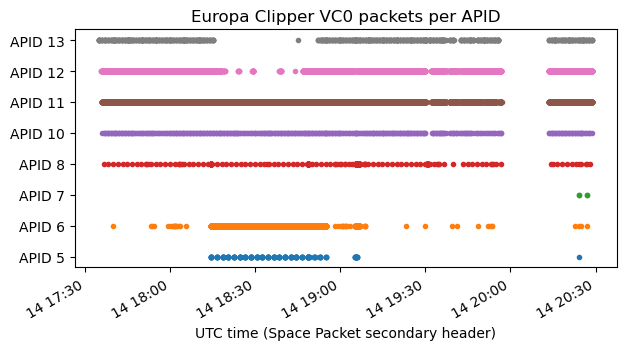

In [19]:
for j, apid in enumerate(sorted([a for a in apids if a != 2047])):
    tstamps = np.array([t for t, h in zip(packet_timestamps, headers_noidle) if h.APID == apid])
    plt.plot(tstamps, [j] * tstamps.size, '.')
yticks = [f'APID {a}' for a in sorted(apids) if a != 2047]
plt.yticks(np.arange(len(yticks)), yticks)
plt.gcf().autofmt_xdate()
plt.title('Europa Clipper VC0 packets per APID')
plt.xlabel('UTC time (Space Packet secondary header)');

In [20]:
Tavg_s = 60
Tavg = Tavg_s * np.timedelta64(1, 's')
boundaries = packet_timestamps[0] + Tavg * np.arange(int(np.ceil((packet_timestamps[-1] - packet_timestamps[0])/Tavg)))

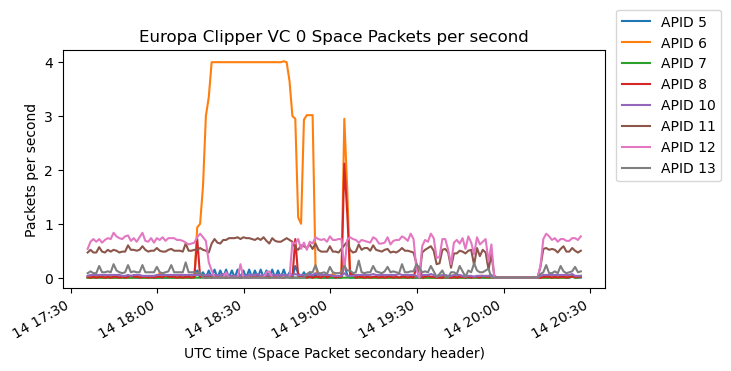

In [21]:
for apid in sorted(apids):
    if apid == 2047:
        continue
    packets_per_second = [sum([1 / Tavg_s for t, h in zip(packet_timestamps, headers_noidle)
                               if h.APID == apid and boundaries[j] <= t < boundaries[j+1]])
                          for j in range(len(boundaries)-1)]
    plt.plot(boundaries[:-1], packets_per_second, '-', label=f'APID {apid}')
plt.legend(loc=(1.02, 0.45))
plt.gcf().autofmt_xdate()
plt.title('Europa Clipper VC 0 Space Packets per second')
plt.ylabel('Packets per second')
plt.xlabel('UTC time (Space Packet secondary header)');

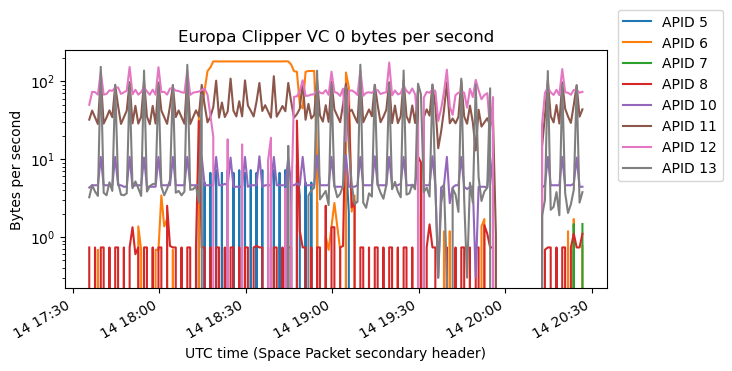

In [22]:
for apid in sorted(apids):
    if apid == 2047:
        continue
    packets_per_second = [sum([len(p) / Tavg_s for p, t, h in zip(packets_noidle, packet_timestamps, headers_noidle)
                               if h.APID == apid and boundaries[j] <= t < boundaries[j+1]])
                          for j in range(len(boundaries)-1)]
    plt.semilogy(boundaries[:-1], packets_per_second, '-', label=f'APID {apid}')
plt.legend(loc=(1.02, 0.45))
plt.gcf().autofmt_xdate()
plt.title('Europa Clipper VC 0 bytes per second')
plt.ylabel('Bytes per second')
plt.xlabel('UTC time (Space Packet secondary header)');

In [23]:
[p[6+6:] for p in by_apid[5][:10]]

[b'0F0106\x0f\x15\x00\x14\x00\x00F#\x00\x00\x00\xad\x01\x02\x0e\x10',
 b'0F0106\x0f\x15\x00\x16\x00\x00F%\x00\x00\x00\xae\x00',
 b'0F0106\x0f\x15\x00\x17\x00\x00F&\x00\x00\x00\xaf\x00',
 b'0A0107\n\x10\x00\xfc\x00\x00F\\\x00\x00\x00\xb0\x01\x04\x00\x00\x00\x00',
 b'0A0107\n\x10\x00\xfc\x00\x00F]\x00\x00\x00\xb1\x01\x04\x00\x00\x00\x01',
 b'0F0106\x0f\x15\x00\x18\x00\x00Fu\x00\x00\x00\xb2\x01\x02\x08\x0c',
 b'0F0106\x0f\x15\x00\x19\x00\x00Fv\x00\x00\x00\xb3\x02\x04\x00\x00\x00 \x04\x00\x00\x00\x01',
 b'0F0106\x0f\x15\x00M\x00\x00F|\x00\x00\x00\xb4\x04\x04\x00\x00\x00 \x08?\xfel,@\x00\x00\x00\x08?\xfe<7\xc0\x00\x00\x00\x04\x00\x00\x00\x01',
 b'0F0106\x0f\x15\x00\x19\x00\x00F\xf2\x00\x00\x00\xb5\x02\x04\x00\x00\x00 \x04\x00\x00\x00\x00',
 b'0F0106\x0f\x15\x00\x19\x00\x00F\xf3\x00\x00\x00\xb6\x02\x04\x00\x00\x00!\x04\x00\x00\x00\x01']

In [24]:
collections.Counter([p[6+6:][:6] for p in by_apid[5]])

Counter({b'0F0106': 174, b'0A0107': 16, b'0A0108': 1, b'040108': 1})

In [25]:
[p[6+6:] for p in by_apid[6][:10]]

[b'010A11\x02\n\x02\x1f\x00\x00E\xf9\x00\x00\x0b\xdd\x02\x04\x00\x00\x00\x02\x04\x00\x00\x00\x15',
 b'0E0106\x02\n\x02\x1f\x00\x00F\x04\x00\x00\x0b\xde\x02\x04\x00\x00\x00\t\x04\x00\x00\x00\x17',
 b'030106\x02\n\x02\x1f\x00\x00F\x06\x00\x00\x0b\xdf\x02\x04\x00\x00\x00\x07\x04\x00\x00\x00\x17',
 b'0D0106\x02\n\x02\x1f\x00\x00F\x07\x00\x00\x0b\xe0\x02\x04\x00\x00\x00\x0b\x04\x00\x00\x00\x17',
 b'020A06\x02\n\x02\x1f\x00\x00F\x0b\x00\x00\x0b\xe1\x02\x04\x00\x00\x00\n\x04\x00\x00\x00\x17',
 b'040106\x02\n\x02\x1f\x00\x00F\r\x00\x00\x0b\xe2\x02\x04\x00\x00\x00\t\x04\x00\x00\x00\x17',
 b'0C0106\x02\n\x02\x1f\x00\x00F\x0e\x00\x00\x0b\xe3\x02\x04\x00\x00\x00\t\x04\x00\x00\x00\x17',
 b'060106\x02\n\x02\x1f\x00\x00F\x0f\x00\x00\x0b\xe4\x02\x04\x00\x00\x00\n\x04\x00\x00\x00\x17',
 b'110106\x02\n\x02\x1f\x00\x00F\x10\x00\x00\x0b\xe5\x02\x04\x00\x00\x00\r\x04\x00\x00\x00\x17',
 b'070106\x02\n\x02\x1f\x00\x00F\x12\x00\x00\x0b\xe6\x02\x04\x00\x00\x00\x08\x04\x00\x00\x00\x17']

In [26]:
collections.Counter([p[6+6:][:6] for p in by_apid[6]])

Counter({b'0A0107': 8489,
         b'0C0107': 168,
         b'110106': 48,
         b'0F0106': 24,
         b'0A0108': 24,
         b'0D0106': 19,
         b'0B0106': 15,
         b'0F0107': 13,
         b'0B0107': 7,
         b'020A06': 5,
         b'060106': 4,
         b'010A11': 3,
         b'0E0106': 3,
         b'030106': 3,
         b'040106': 2,
         b'0C0106': 2,
         b'070106': 2,
         b'0A0106': 2,
         b'090106': 2,
         b'050106': 2,
         b'060B0E': 1,
         b'040108': 1})

In [27]:
[p[6+6:] for p in by_apid[7]]

[b'040108\x04\x0c\x00\x14\x00\x00k\xee\x00\x00\x02$\x04\x04\x00\x00\xfb\x91\x02\x00\x8c\x04\x1b\xd0B\xaf\x04\x89\xdb\x00\x00',
 b'040108\x04\x0c\x00\x16\x00\x00k\xf0\x00\x00\x02%\x02\x04\x00\x00\xfb\x91\x02\x00\x8c',
 b'040108\x04\x0c\x00\x14\x00\x00k\xf5\x00\x00\x02&\x04\x04\x00\x00\xfeO\x02\x00\x8d\x04\x1b\xd0CI\x04!\xdb\x80\x00',
 b"040108\x04\x0c\x00\x16\x00\x00k\xf7\x00\x00\x02'\x02\x04\x00\x00\xfeO\x02\x00\x8d"]

In [28]:
[p[6+6:] for p in by_apid[8][:10]]

[b'0A0107\n\x1c\x009\x00\x00E\xf7\x00\x00\x15\x95\x03\x08A\xbb\xd0\x1b]h\x07\xb0\x01\x00\x01\x01',
 b'0A0107\n\x1c\x009\x00\x00E\xf8\x00\x00\x15\x96\x03\x08A\xbb\xd0\x1b\xc1h\x07\xb0\x01\x01\x01\x00',
 b'0A0107\n\x1c\x009\x00\x00E\xfa\x00\x00\x15\x97\x03\x08A\xbb\xd0\x1c%h\x07\xc0\x01\x00\x01\x01',
 b'0A0107\n\x1c\x009\x00\x00E\xfb\x00\x00\x15\x98\x03\x08A\xbb\xd0\x1c\x89h\x07\xc0\x01\x01\x01\x00',
 b'0A0107\n\x1c\x009\x00\x00E\xfc\x00\x00\x15\x99\x03\x08A\xbb\xd0\x1c\xedh\x07\xc0\x01\x00\x01\x01',
 b'0A0107\n\x1c\x009\x00\x00E\xfd\x00\x00\x15\x9a\x03\x08A\xbb\xd0\x1dQh\x07\x80\x01\x01\x01\x00',
 b'0A0107\n\x1c\x009\x00\x00E\xfe\x00\x00\x15\x9b\x03\x08A\xbb\xd0\x1d\xb5h\x07\xa0\x01\x00\x01\x01',
 b'0A0107\n\x1c\x009\x00\x00E\xff\x00\x00\x15\x9c\x03\x08A\xbb\xd0\x1e\x19h\x07\x90\x01\x01\x01\x00',
 b'0A0107\n\x1c\x009\x00\x00F\x00\x00\x00\x15\x9d\x03\x08A\xbb\xd0\x1e}h\x07\xa0\x01\x00\x01\x01',
 b'0E0107\x0e\x0f\xe0\x7f\x00\x00F\x01\x00\x00\x15\x9e\x01\x04\x00\x00\x00\x01']

In [29]:
collections.Counter([p[6+6:][:6] for p in by_apid[8]])

Counter({b'0A0107': 188,
         b'0A0108': 60,
         b'110106': 43,
         b'0B0106': 42,
         b'0F0107': 33,
         b'0B0107': 14,
         b'0F0106': 10,
         b'020A06': 6,
         b'030D0E': 6,
         b'040E0D': 5,
         b'0E0107': 4,
         b'040106': 4,
         b'040107': 3,
         b'060B0E': 2,
         b'040108': 2,
         b'0D0106': 1})

# VC 63

Virtual channel 63 carries idle packets from APID 2047. Their sequence count draws from the same counter as the idle packets in VC 32, and they are also filled with the easter egg message, padded with `0x00` bytes at the end if needed to fill the whole AOS frame. For some reason the first header pointer isn't 0.

In [30]:
[a for a in tm if a.primary_header.virtual_channel_id == 63]

[Container(primary_header=Container(transfer_frame_version_number=1, spacecraft_id=159, virtual_channel_id=63, virtual_channel_frame_count=6671663, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0), m_pdu_header=Container(rsv_spare=0, first_header_pointer=5), m_pdu_packet_zone=b'\xd9\xa9\x00\x00N\x07\xff\xd9\xaa\x04EN.Alderson M.Aleem K.Altimus R.Banduric A.Black\nI.Brault J.Brown B.Campuzano B.Chen S.Cheng S.Chou\nN.Chow T.Clark N.Colindres D.Cummings J.Davis\nA.Diaz-Calderon A.Dobrev P.Doronila B.Duckett\nJ.Fernandez D.Gaines G.Gandhi R.Gio K.Gov D.Hahn\nL.Hall S.Harris J.Hennawy K.Jones M.Jordan R.Joshi\nD.Karlsson C.Kellerman D.Kessler S.Khan J.Kochocki\nR.Largaespada L.Manglapus N.Markovitch S.Mikaelian\nL.Miller B.Morin N.Nguyen A.Niessner C.Oda\nC.Parker P.Partikian J.Pelayo I.Peng S.Reddy\nL.Reder K.Reinholtz M.Rodriguez-Chen K.Roffo\nP.Romano K.Rosario M.Sandoval T.Seto-Mook C.Skeggs\nA.Smith D.Tran M.Tuszynski I.Uchenik M.Wade E.Wang\nC.

In [31]:
packets_vc63 = list(ccsds.extract_space_packets(tm, 0x9f, 63))
headers_vc63 = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets_vc63]

In [32]:
headers_vc63

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6570, data_length=1093),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=6845, data_length=1097)]

In [33]:
packets_vc63

[b'\x07\xff\xd9\xaa\x04EN.Alderson M.Aleem K.Altimus R.Banduric A.Black\nI.Brault J.Brown B.Campuzano B.Chen S.Cheng S.Chou\nN.Chow T.Clark N.Colindres D.Cummings J.Davis\nA.Diaz-Calderon A.Dobrev P.Doronila B.Duckett\nJ.Fernandez D.Gaines G.Gandhi R.Gio K.Gov D.Hahn\nL.Hall S.Harris J.Hennawy K.Jones M.Jordan R.Joshi\nD.Karlsson C.Kellerman D.Kessler S.Khan J.Kochocki\nR.Largaespada L.Manglapus N.Markovitch S.Mikaelian\nL.Miller B.Morin N.Nguyen A.Niessner C.Oda\nC.Parker P.Partikian J.Pelayo I.Peng S.Reddy\nL.Reder K.Reinholtz M.Rodriguez-Chen K.Roffo\nP.Romano K.Rosario M.Sandoval T.Seto-Mook C.Skeggs\nA.Smith D.Tran M.Tuszynski I.Uchenik M.Wade E.Wang\nC.Williams V.Woo P.Dunn S.Hornbeck S.Lai A.Moncada\nT.Neilson M.Thielman J.Walker T.Wysocky J.Lam\nG.Singh C.Ballard J.Berman J.Bowles-Martinez\nC.Brennan B.Cantos J.Castet E.Dodd M.Jackson\nA.Kerzhner R.Kinnett G.Lee R.Morillo M.Salami\nB.Smith M.Soriano C.Swan B.Ferdowsi D.Hecox\nA.Holloway C.Hua C.Jones D.Kou J.Lai D.Leang\nS.Scan

In [34]:
[len(p) for p in packets_vc63]

[1100, 1104]

In [35]:
[h.data_length + 7 for h in headers_vc63]

[1100, 1104]

In [36]:
print(str(packets_vc63[1][6:], encoding='ascii'))

N.Alderson M.Aleem K.Altimus R.Banduric A.Black
I.Brault J.Brown B.Campuzano B.Chen S.Cheng S.Chou
N.Chow T.Clark N.Colindres D.Cummings J.Davis
A.Diaz-Calderon A.Dobrev P.Doronila B.Duckett
J.Fernandez D.Gaines G.Gandhi R.Gio K.Gov D.Hahn
L.Hall S.Harris J.Hennawy K.Jones M.Jordan R.Joshi
D.Karlsson C.Kellerman D.Kessler S.Khan J.Kochocki
R.Largaespada L.Manglapus N.Markovitch S.Mikaelian
L.Miller B.Morin N.Nguyen A.Niessner C.Oda
C.Parker P.Partikian J.Pelayo I.Peng S.Reddy
L.Reder K.Reinholtz M.Rodriguez-Chen K.Roffo
P.Romano K.Rosario M.Sandoval T.Seto-Mook C.Skeggs
A.Smith D.Tran M.Tuszynski I.Uchenik M.Wade E.Wang
C.Williams V.Woo P.Dunn S.Hornbeck S.Lai A.Moncada
T.Neilson M.Thielman J.Walker T.Wysocky J.Lam
G.Singh C.Ballard J.Berman J.Bowles-Martinez
C.Brennan B.Cantos J.Castet E.Dodd M.Jackson
A.Kerzhner R.Kinnett G.Lee R.Morillo M.Salami
B.Smith M.Soriano C.Swan B.Ferdowsi D.Hecox
A.Holloway C.Hua C.Jones D.Kou J.Lai D.Leang
S.Scandore A.StAmand V.Verma K.Weiss

and many oth